<a href="https://colab.research.google.com/github/hyulianton/BigData/blob/main/Proyek_Big_Data_Mahasiswa_Analisis_Sentimen_Ulasan_Produk_E_Commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Java Development Kit versi 8

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Download spark versi 3.5.6

In [2]:
!wget https://downloads.apache.org/spark/spark-3.5.6/spark-3.5.6-bin-hadoop3.tgz

--2025-07-01 13:43:49--  https://downloads.apache.org/spark/spark-3.5.6/spark-3.5.6-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.208.237, 2a01:4f8:10a:39da::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400923510 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.6-bin-hadoop3.tgz’

spark-3.5.6-bin-had 100%[===================>] 382.35M  25.7MB/s    in 16s     

2025-07-01 13:44:05 (24.6 MB/s) - ‘spark-3.5.6-bin-hadoop3.tgz’ saved [400923510/400923510]



Ekstrak spark

In [3]:
!tar -xf spark-3.5.6-bin-hadoop3.tgz

Setting environment variable

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.6-bin-hadoop3"

Install library spark

In [5]:
!pip install findspark -q -q -q
!pip install pyspark -q -q -q

# 📊 Proyek Big Data Mahasiswa: Analisis Sentimen Ulasan Produk E-Commerce

## 🎯 Tujuan Proyek
Membangun pipeline Big Data untuk:
- Mengambil dan membersihkan data ulasan produk.
- Melakukan pemrosesan batch menggunakan PySpark.
- Melakukan analisis sentimen menggunakan model machine learning.
- Menyajikan hasil dalam bentuk dashboard visualisasi (menggunakan matplotlib/seaborn atau Streamlit).

---

## 🧱 Arsitektur Data Pipeline

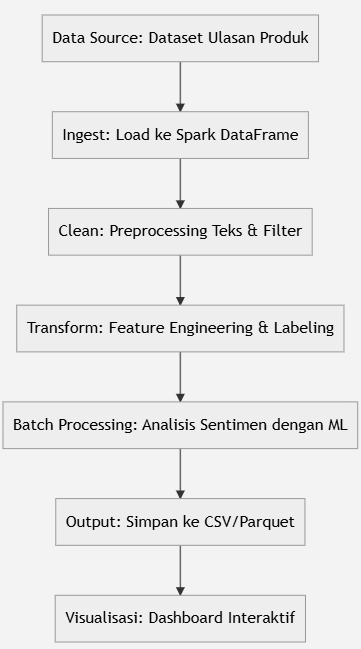

---

## 📦 Dataset
Gunakan dataset `fetch_20newsgroups` dari `sklearn.datasets` sebagai simulasi ulasan produk (karena berisi teks dalam berbagai kategori).

In [6]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='train', categories=['rec.autos', 'sci.electronics'], remove=('headers', 'footers', 'quotes'))

## 🛠️ Implementasi Pipeline dengan PySpark

### 1. 🔽 Ingest Data ke Spark

In [7]:
from pyspark.sql import SparkSession
import pandas as pd

# Inisialisasi Spark
spark = SparkSession.builder.appName("SentimentAnalysisPipeline").getOrCreate()

# Load data dari sklearn
df_pd = pd.DataFrame({'text': data.data, 'label': data.target})
df_spark = spark.createDataFrame(df_pd)
df_spark.show(3)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|hand.\n\nLand Cru...|    0|
|\n I found a Mopa...|    0|
|\nIt seems sad th...|    0|
+--------------------+-----+
only showing top 3 rows



### 2. 🧹 Preprocessing & Cleaning

In [8]:
from pyspark.sql.functions import col, lower, regexp_replace

# Bersihkan teks: lowercase, hapus simbol
df_clean = df_spark.withColumn("clean_text", lower(col("text")))
df_clean = df_clean.withColumn("clean_text", regexp_replace("clean_text", "[^a-zA-Z\\s]", ""))
df_clean = df_clean.filter(col("clean_text").isNotNull())

### 3. 🧠 Feature Engineering & Tokenization

In [9]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
df_words = tokenizer.transform(df_clean)

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_filtered = remover.transform(df_words)

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
featurized_data = hashingTF.transform(df_filtered)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

### 4. 🧪 Model Training (Batch Processing)

In [10]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Siapkan label
indexer = StringIndexer(inputCol="label", outputCol="label_index")
lr = LogisticRegression(featuresCol="features", labelCol="label_index", maxIter=10)

pipeline = Pipeline(stages=[indexer, lr])
model = pipeline.fit(rescaled_data)

# Prediksi
predictions = model.transform(rescaled_data)
predictions.select("label", "prediction").show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
+-----+----------+
only showing top 5 rows



### 5. 📈 Evaluasi & Simpan Output

In [11]:
evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy:.2f}")

# Simpan hasil ke CSV
predictions.select("clean_text", "label", "prediction").write.csv("output_sentiment.csv", header=True, mode="overwrite")

Model Accuracy: 0.99


### 6. 📊 Visualisasi Hasil (Opsional: Streamlit atau Matplotlib)

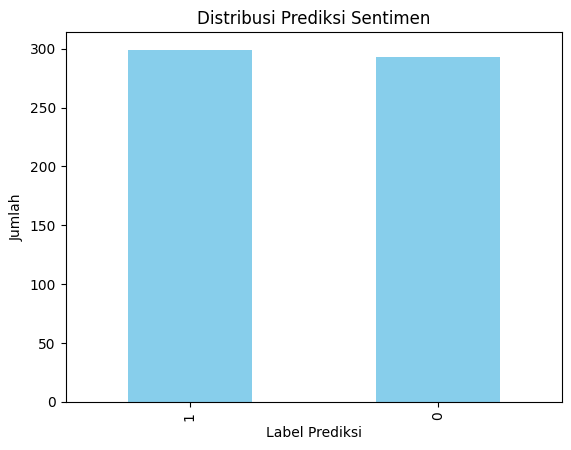

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load hasil
df_result = pd.read_csv("output_sentiment.csv/part-00000.csv")
df_result['prediction'] = df_result['prediction'].astype(int)

# Visualisasi distribusi prediksi
df_result['prediction'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribusi Prediksi Sentimen")
plt.xlabel("Label Prediksi")
plt.ylabel("Jumlah")
plt.show()

## ✅ Hasil & Dampak Nyata

| Komponen                  | Penjelasan                                                                 |
|---------------------------|----------------------------------------------------------------------------|
| Data Pipeline             | Mahasiswa membangun pipeline dari ingestion hingga output CSV              |
| Batch Processing          | Menggunakan PySpark untuk preprocessing dan training model secara batch    |
| Machine Learning          | Logistic Regression untuk klasifikasi sentimen                            |
| Hasil Nyata               | Akurasi model, distribusi prediksi, dan dashboard visualisasi              |
| Kesiapan Industri         | Mahasiswa memahami proses end-to-end seperti yang dibutuhkan di dunia kerja|

---

## 💡 Pengembangan Lanjutan
- Gunakan Kafka untuk real-time ingestion.
- Integrasi dengan dashboard interaktif via Streamlit atau Grafana.
- Simpan hasil ke data lake (misalnya HDFS atau S3).
- Gunakan model pre-trained seperti BERT untuk peningkatan akurasi.